In [1]:
import sklearn
from sysid.subspace_cupy_fp16 import subspace_det_algo1, prbs, nrms, symmetric_mean_absolute_percentage_error, \
    index_of_agreement, mean_absolute_percentage_error, mean_absolute_scaled_error
from sysid.ss_cupy_fp16 import StateSpaceDiscreteLinear, StateSpaceDataList, StateSpaceDataArray
from sklearn.metrics import r2_score
import time
import pandas as pd
import cupy as np
import numpy
import matplotlib.pyplot as plt

In [2]:
#Virtual DATA
tf = 20  # 365 * 5
dt = 1
plot_stuff = True

u_dimensions = 2
y_dimensions = 2

data_u = np.random.randn(u_dimensions, tf)  # 40 * 45
# data_y = np.random.randn(3, tf)  # 40 * 45
white_noise = 0.1 *  np.random.randn(y_dimensions, tf)
uniform_noise = 0.1 *  np.random.rand(y_dimensions, tf)
data_y2 = 80 + 30 * (data_u[0:y_dimensions,:] + white_noise + uniform_noise) # 40 * 45

# Regularize data
data_y = (data_y2 - np.mean(data_y2)) / np.std(data_y2)

data_y.shape

(2, 20)

In [3]:
# TODO:
# 1. time-series split
# 2. 3 days ahead predict
# 3. Island transpeciation search
# 4. 50% MSE + 50% residuals corr & autocorr error

In [4]:
# S&P 500 DATA

days = tf = 365 * 5 # Total simulation days
total_days = tf * 2

total_top_correlated = 220 # Max (correlated) input ticker count
days_fill_range = days
time_step = dt = 1  # Time-step scale (1 day)

plot_stuff = True
df1 = pd.read_csv('sp500_joined_closes.csv')
df1 = df1.set_index("Date")
df1= df1.astype(float)

df1 = df1.dropna(axis='columns')  # Drop columns with NA

df1 = df1.interpolate(limit=days_fill_range)
df1 = df1.ffill(limit=days_fill_range).bfill(limit=days_fill_range)

df = df1.tail(total_days)
min_max_df = (df-df.min())/(df.max()-df.min())
standardized_df = (df-df.mean())/(df.std())
normalized_df = standardized_df

# normalized_df = normalized_df.interpolate(limit=days_fill_range)
# normalized_df = normalized_df.bfill(limit=days_fill_range).ffill(limit=days_fill_range)
y_labels = ["MSFT", "AMD", "AAPL", "INTC"]

corr0 = normalized_df.corr(method="spearman").abs()  # Allow negative correlations
corr1 = corr0[corr0 <0.99999]  # Remove correlations == 100%
corr2 = corr1[corr1>0.5]  # Remove half correlated
corr3 = corr2.unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates() # Sort by most correlated

total_top_correlated = min(total_top_correlated, normalized_df.shape[1])

u_labels = []  # Add the top correlated tickers to the inputs
for y_label in y_labels:
    u_labels = u_labels + corr3[y_label].head(int(total_top_correlated/len(y_labels))).index.tolist()
    
u_labels = list(dict.fromkeys(u_labels))  # Remove duplicate tickers
for y_label in y_labels:  # Remove output tickers from inputs
    if y_label in u_labels:
        u_labels.remove(y_label)

print("NaNs?", normalized_df[u_labels + y_labels].isnull().values.any())

# data_u = normalized_df[u_labels].tail(tf).values.T
# data_y = normalized_df[y_labels].tail(tf).values.T

data_u = normalized_df[u_labels].tail(total_days).head(tf).values.T
data_y = normalized_df[y_labels].tail(total_days).head(tf).values.T

test_data_u = normalized_df[u_labels].tail(tf).values.T
test_data_y = normalized_df[y_labels].tail(tf).values.T

u_dimensions = len(u_labels)
y_dimensions = len(y_labels)

NaNs? False


In [5]:
# import numpy as np
# from sklearn.model_selection import TimeSeriesSplit
# # X = np.array([[1, 2, 5], [3, 5, 4], [1, 5, 2], [3, 5, 4], [1, 5, 2], [3, 5, 4], [1, 5, 34], [5, 5, 7]])
# X = data_u[0]
# y = data_y[0]
# # y = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4], [1, 34], [5, 7]])
# tscv = TimeSeriesSplit(max_train_size=int(0.75* X.shape[0]), n_splits=2)
# print(tscv)
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
# # print(X_train, X_test)


In [6]:
print("data_u.shape: {}, data_y.shape: {}".format(data_u.shape, data_y.shape))
print("MIMO [{} IN, {} OUT], {} time-steps.".format(data_u.shape[0], data_y.shape[0], data_u.shape[1]))

def f_prbs_3d(t, x, i):
    return np.array([data_u[:, i]], dtype=numpy.float16).T

start_time = time.time()  # Serial
ss3_id = subspace_det_algo1(y=data_y, u=data_u,
    f=5,  # 5 Forward steps
    p=5,  # 5 Backward steps
    s_tol=0.01,  # 0.2
    dt=dt,
    order=-1)
print("--- GPU Execution time:\t\t{} seconds".format(time.time() - start_time))

data_u.shape: (145, 1825), data_y.shape: (4, 1825)
MIMO [145 IN, 4 OUT], 1825 time-steps.
--- GPU Execution time:		4.80949330329895 seconds


In [7]:
# TODO: test data here to simulate (should be similar)
data3_id = ss3_id.simulate(
    f_u=f_prbs_3d,
    x0=np.array([np.zeros(ss3_id.A.shape[0], dtype=numpy.float16)], dtype=numpy.float16).T,
    tf=tf)

TRAIN: Total NRMSE: 1.538
TRAIN: Total sMAPE: 134.3%
TRAIN: Total IOA: 26.3%


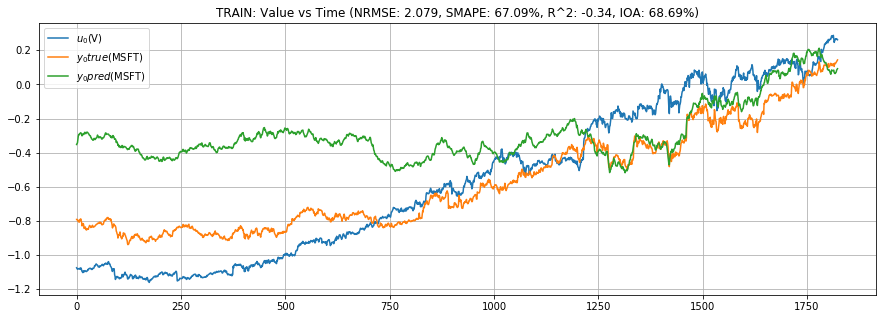

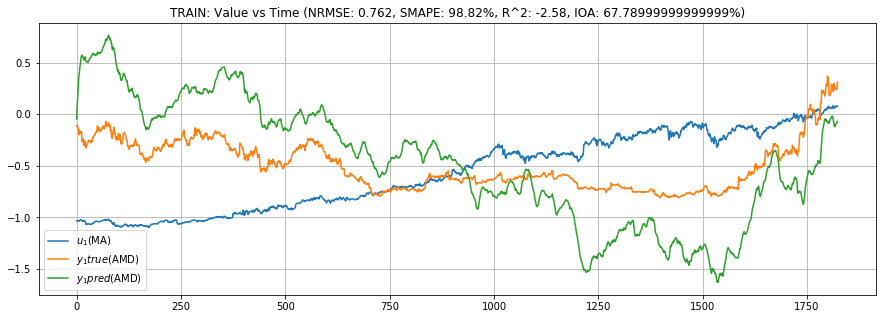

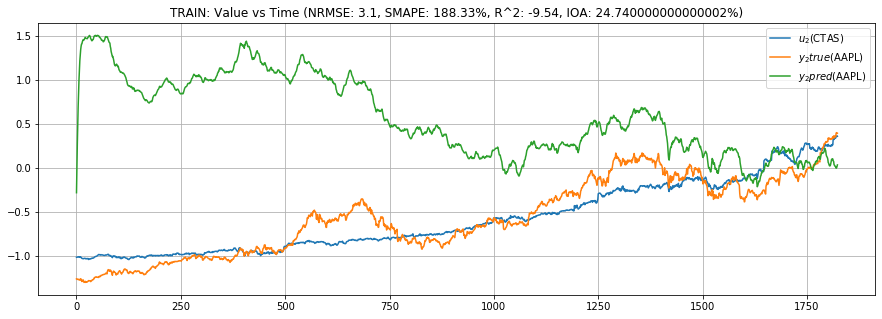

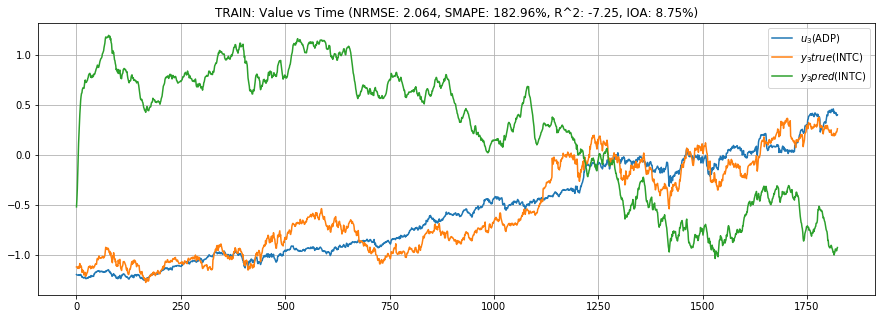

In [8]:
timesteps = data3_id.t.tolist()
for i in range(y_dimensions):    
    plt.figure(figsize=(15,5))
    plt.plot(timesteps, data3_id.u[:,i,:][0].tolist(), label='$u_{:d}$({})'.format(i, u_labels[i]))   
    plt.plot(timesteps, data_y[i,:-1].tolist(), label='$y_{:d}true$({})'.format(i, y_labels[i]))         
    plt.plot(timesteps, data3_id.y[:,i,:][0].tolist(), label='$y_{:d} pred$({})'.format(i, y_labels[i]))
    plt.legend()
    plt.grid()
    
    plt.title("TRAIN: Value vs Time (NRMSE: {}, SMAPE: {}%, R^2: {}, IOA: {}%)".format(
        round(float(nrms(np.array(data_y[i, :-1]), np.array(data3_id.y[:,i,:][0]))), 3), 
        round(float(symmetric_mean_absolute_percentage_error(np.array(data_y[i, :-1]),np.array(data3_id.y[:,i,:][0]))), 2),
        round(float(r2_score(data_y[i, :-1].tolist(), data3_id.y[:,i,:][0].tolist())), 2),
        100 * round(float(index_of_agreement(np.array(data_y[i, :-1]),np.array(data3_id.y[:,i,:][0]))), 4)
    ))

print("TRAIN: Total NRMSE: {}".format(round(float(nrms(np.array(data_y[:, :-1]),np.array(data3_id.y[0]))), 3)))
print("TRAIN: Total sMAPE: {}%".format(round(float(symmetric_mean_absolute_percentage_error(np.array(data_y[:, :-1]),np.array(data3_id.y[0]))), 2)))
print("TRAIN: Total IOA: {}%".format(100 * round(float(index_of_agreement(np.array(data_y[:, :-1]),np.array(data3_id.y[0]))), 4)))

In [9]:
def f_prbs_4d(t, x, i):
    return np.array([test_data_u[:, i]], dtype=numpy.float16).T

# TODO: test data here to simulate (should be similar)
data4_id = ss3_id.simulate(
    f_u=f_prbs_4d,
    x0=np.array([np.zeros(ss3_id.A.shape[0], dtype=numpy.float16)], dtype=numpy.float16).T,
    tf=tf)

TEST: Total NRMSE: 1.513
TEST: Total sMAPE: 156.52%
TEST: Total IOA: 46.06%


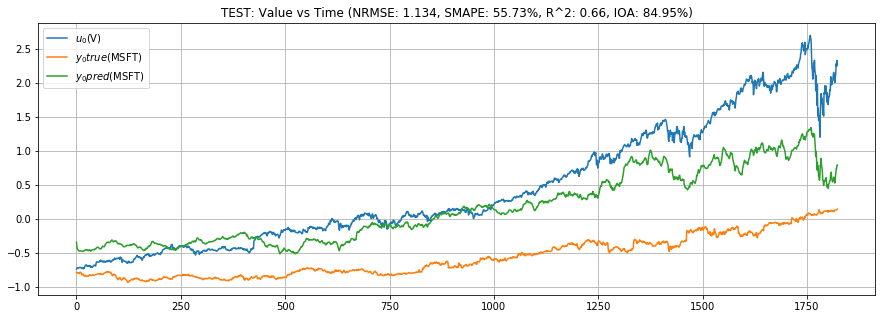

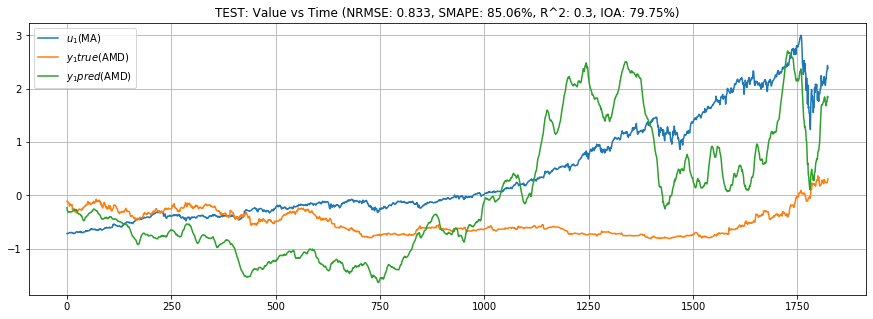

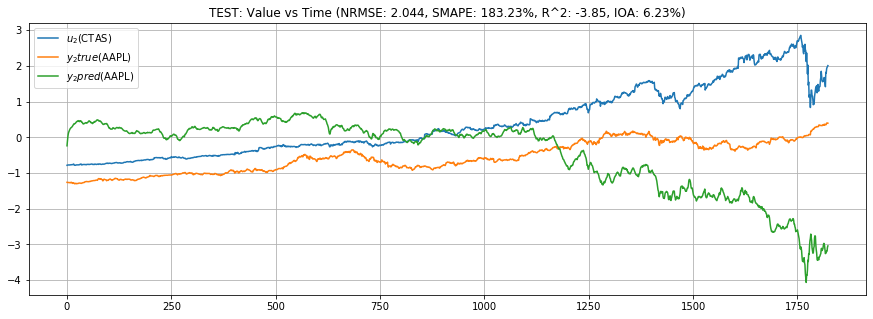

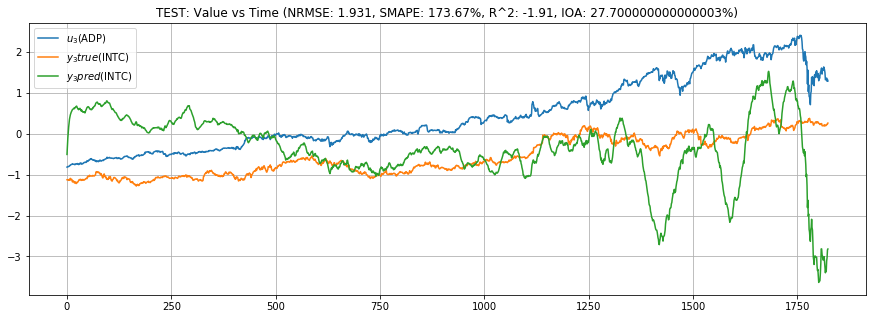

In [10]:
timesteps = data4_id.t.tolist()
for i in range(y_dimensions):    
    plt.figure(figsize=(15,5))
    plt.plot(timesteps, data4_id.u[:,i,:][0].tolist(), label='$u_{:d}$({})'.format(i, u_labels[i]))   
    plt.plot(timesteps, data_y[i,:-1].tolist(), label='$y_{:d}true$({})'.format(i, y_labels[i]))         
    plt.plot(timesteps, data4_id.y[:,i,:][0].tolist(), label='$y_{:d} pred$({})'.format(i, y_labels[i]))
    plt.legend()
    plt.grid()
    
    plt.title("TEST: Value vs Time (NRMSE: {}, SMAPE: {}%, R^2: {}, IOA: {}%)".format(
        round(float(nrms(np.array(test_data_y[i, :-1]), np.array(data4_id.y[:,i,:][0]))), 3), 
        round(float(symmetric_mean_absolute_percentage_error(np.array(test_data_y[i, :-1]),np.array(data4_id.y[:,i,:][0]))), 2),
        round(float(r2_score(test_data_y[i, :-1].tolist(), data4_id.y[:,i,:][0].tolist())), 2),
        100 * round(float(index_of_agreement(np.array(test_data_y[i, :-1]),np.array(data4_id.y[:,i,:][0]))), 4)
    ))

print("TEST: Total NRMSE: {}".format(round(float(nrms(np.array(test_data_y[:, :-1]),np.array(data4_id.y[0]))), 3)))
print("TEST: Total sMAPE: {}%".format(round(float(symmetric_mean_absolute_percentage_error(np.array(test_data_y[:, :-1]),np.array(data3_id.y[0]))), 2)))
print("TEST: Total IOA: {}%".format(100 * round(float(index_of_agreement(np.array(test_data_y[:, :-1]),np.array(data4_id.y[0]))), 4)))